In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os
import pytest
from google.colab import drive
import pandas as pd
import math
import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.init as init
from sklearn.preprocessing import MinMaxScaler

In [2]:
# auxiliary functions for data loading
def df_to_X_y(df):
  df_as_np = df.to_numpy()

  X = df_as_np[:-1, :] # daily values (open, high, low and close)
  Y = df_as_np[1:, -1] # the target is the closing price of the next day

  return X.astype(np.float32), Y.astype(np.float32)

def str_to_datetime(s): # used to convert the date into an index
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

Mounted at /content/drive


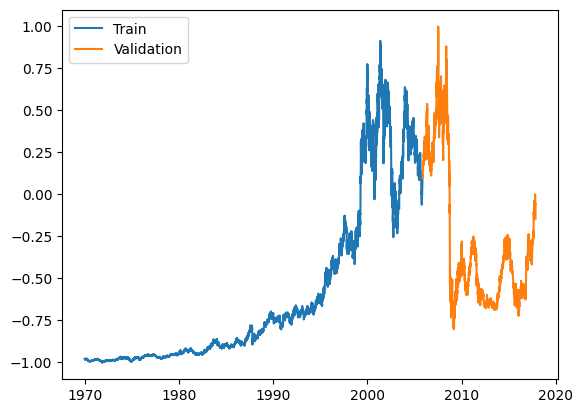

In [3]:
drive.mount('/content/drive')
data_path = '/content/drive/Shared drives/Deep Learning/Final/Data/' # modify path accordingly
df = pd.read_csv(data_path + "aa.us.csv") # use data following the same structure as this csv
results_path = '/content/drive/Shared drives/Deep Learning/Final/Results/'

df['Date'] = df['Date'].apply(str_to_datetime)
df = df[['Date', 'Open', 'High', 'Low', 'Close']]
df.index = df.pop('Date')
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

q_80 = int(len(df['Close']) * .75)

# split training and testing data
train = df.iloc[:q_80, :]
test = df.iloc[q_80:, :]

# the dataset below are already np arrays
X_train, y_train = df_to_X_y(train)
X_test, y_test = df_to_X_y(test)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

plt.plot(train["Close"])
plt.plot(test["Close"])
plt.legend(['Train', 'Validation'])

In [4]:
dataset_train = np.hstack((X_train, y_train))
dataset_test = np.hstack((X_test, y_test))
len_train = len(dataset_train)
len_test = len(dataset_test)
len_seq = 50

"""
structure of one element:

feature feature feature feature ignore
feature feature feature feature ignore
feature feature feature feature ignore
feature feature feature feature target

using sliding windows
right most columns are the closing price of the next day
the first for columns are the open, high, low and close of the current day
"""

class MyDataset(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = self.data[index:index + self.window, :-1] # keeping all features except the last column
        y = self.data[index+self.window, -1] # target from last element --> last column (target)
        return x, y

    def __len__(self):
        return len(self.data) - self.window

dataset_train = MyDataset(dataset_train, len_seq)
dataset_test = MyDataset(dataset_test, len_seq)

data_loader_train = DataLoader(dataset_train, batch_size=len_seq)
data_loader_test = DataLoader(dataset_test, batch_size=1) # loading one sequence at a time

In [5]:
class StockLN(nn.Module):
    def __init__(self, input_dims, hidden_size, num_layers):
        super(StockLN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

        self.lstm = nn.LSTM(input_size=input_dims, hidden_size=hidden_size, num_layers=num_layers, dropout=0.3, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

        self.do = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size, seq_len, num_features = x.size()

        # reshape to combine batch and sequence dimensions for CNN
        x = x.view(batch_size * seq_len, 1, num_features, 1)

        # the convolution is used to extract local feature for each seq
        # in practice it behaves faster but does not help
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)

        # reshape back to (batch_size, seq_len, num_features) to fit a time-series problem
        x = x.view(batch_size, seq_len, num_features)

        # extract temporal dependencies
        x, _ = self.lstm(x)
        x = x[-1, -1, :]
        x = self.fc1(x)
        x = self.do(x)
        x = self.fc2(x)
        return x

In [14]:
def train_test_model(model, criterion, optimizer, train_loader, test_loader, epochs, tolerance):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    loss_list = []
    for epoch in range(epochs):
        model.train()
        total_step = len(train_loader)
        for i, (features, labels) in enumerate(train_loader):
            features = features.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(features)
            loss = criterion(outputs.squeeze(), labels[-1]) # squeeze() because before it was [1], to convert it to [] (scalar)
                                                            # only use label of last element of sequence because it is the only necessary one
            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.7)
            optimizer.step()

            loss_list.append(loss.item())
            if (epoch % 15 == 0) and (i==total_step-1):
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, epochs, i+1, total_step, loss.item()))

    # save the model checkpoint for transfer learning
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    torch.save(model.state_dict(), os.path.join(results_path, 'model.ckpt'))


    # testing
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)

            # network predictions
            outputs = model(features)

            within_tolerance = torch.abs(outputs.squeeze() - labels[-1]) <= tolerance

            if within_tolerance == True:
                correct+=1

        total = len_test
        test_accuracy = 100 * correct / total
        print('Final test Accuracy of the model: {:.2f} %'.format(test_accuracy))

    return loss_list


def predict(model, train_loader, test_loader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    model.eval()
    with torch.no_grad():
        total = 0
        predictions = []
        labels_plot = []

        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            # network predictions
            outputs = model(features)
            predictions.append(outputs.squeeze().cpu().numpy())
            labels_plot.append(labels[-1].cpu().numpy())

    plt.figure(figsize=(10, 5))
    plt.plot(predictions, label='Predictions', color='blue')
    plt.plot(labels_plot, label='Actual Labels', color='orange')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title('Model Predictions vs Actual Labels')
    plt.legend()
    plt.show()

    return predictions

Epoch [1/250], Step [181/181], Loss: 0.0033
Epoch [16/250], Step [181/181], Loss: 0.0179
Epoch [31/250], Step [181/181], Loss: 0.0007
Epoch [46/250], Step [181/181], Loss: 0.0069
Epoch [61/250], Step [181/181], Loss: 0.0107
Epoch [76/250], Step [181/181], Loss: 0.0046
Epoch [91/250], Step [181/181], Loss: 0.0003
Epoch [106/250], Step [181/181], Loss: 0.0000
Epoch [121/250], Step [181/181], Loss: 0.0017
Epoch [136/250], Step [181/181], Loss: 0.0001
Epoch [151/250], Step [181/181], Loss: 0.0163
Epoch [166/250], Step [181/181], Loss: 0.0000
Epoch [181/250], Step [181/181], Loss: 0.0151
Epoch [196/250], Step [181/181], Loss: 0.0217
Epoch [211/250], Step [181/181], Loss: 0.0026
Epoch [226/250], Step [181/181], Loss: 0.0003
Epoch [241/250], Step [181/181], Loss: 0.0001
Final test Accuracy of the model: 90.36 %


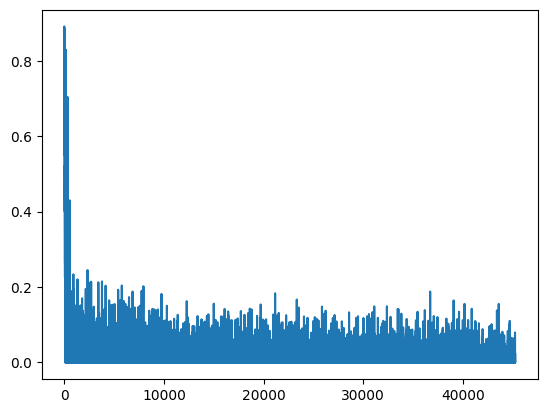

In [15]:
model = StockLN(input_dims=4, hidden_size=32, num_layers=1) # this values proved empirically to be the best performing ones, an excel with different params can be found in the repo
criterion = nn.MSELoss(reduction="mean") # mean squared error loss for regression task
optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_list = train_test_model(model, criterion, optimizer, data_loader_train, data_loader_test,epochs=250,tolerance=0.1)
plt.plot(loss_list)

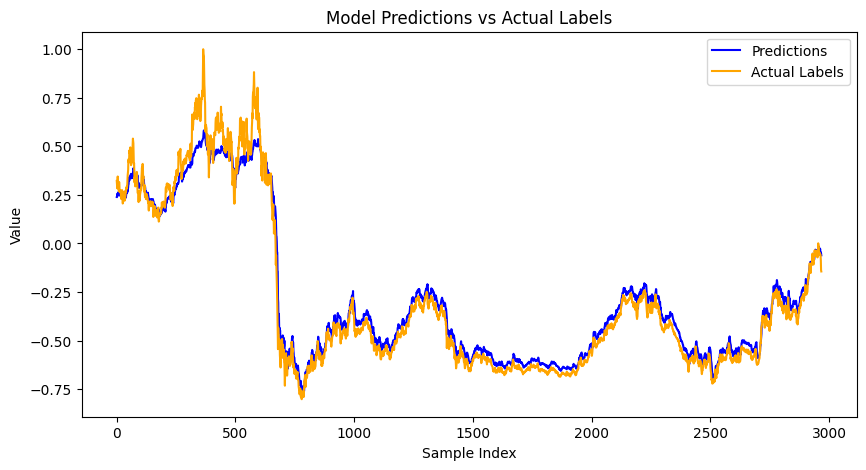

In [16]:
predictions = predict(model, data_loader_train ,data_loader_test)